In [1]:
import tensorflow as tf
import os
import seaborn as sns
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
data_dir = 'Data' 

In [5]:
os.listdir(data_dir)

['Big Ben',
 'Colosseum',
 'Egypt Pyramids',
 'Eiffel Tower',
 'London Bridge',
 'Petra',
 'Statue of Liberty',
 'Sudan Pyramids',
 'Sydney Opera House',
 'Taj Mahal']

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
           

In [8]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 1557 files belonging to 10 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
# Image represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

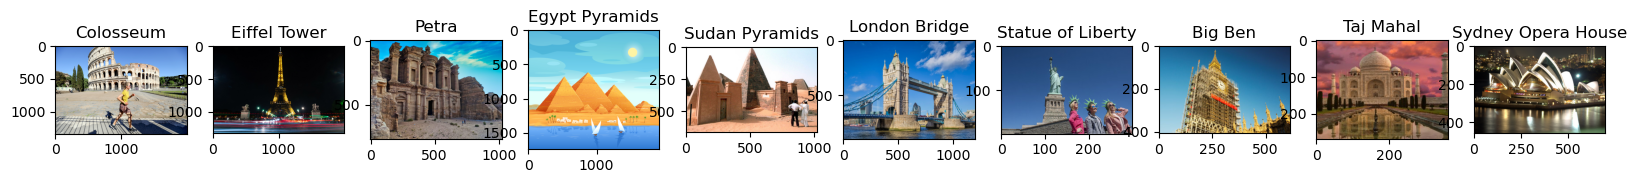

In [12]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, folder in enumerate(['Colosseum', 'Eiffel Tower', 'Petra', 'Egypt Pyramids', 'Sudan Pyramids','London Bridge', 'Statue of Liberty','Big Ben','Taj Mahal','Sydney Opera House']):
    folder_path = os.path.join(data_dir, folder)
    image_files = os.listdir(folder_path)
    image_path = os.path.join(folder_path, image_files[0])  
    img = plt.imread(image_path)
    ax[idx].imshow(img)
    ax[idx].set_title(folder)

In [13]:
# Defining data augmentation transformations
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [15]:
# Spliting the dataset into training and validation
train_size = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=123,
image_size=(160, 160),
batch_size=32)
val_size = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(160, 160),
batch_size=32)

Found 1557 files belonging to 10 classes.
Using 1246 files for training.
Found 1557 files belonging to 10 classes.
Using 311 files for validation.


In [16]:
class_names = train_size.class_names
print(class_names)

['Big Ben', 'Colosseum', 'Egypt Pyramids', 'Eiffel Tower', 'London Bridge', 'Petra', 'Statue of Liberty', 'Sudan Pyramids', 'Sydney Opera House', 'Taj Mahal']


In [17]:
# Applying data augmentation to the training dataset
train_size = train_size.map(lambda x, y: (data_augmentation(x, training=True), y))

In [18]:
# Assigning Test dataset
test_dataset = val_size.take(5)
val_size = val_size.skip(5)

### VGG16 model without applying any fine tuning

In [20]:
# Loading the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

In [21]:
# Loading the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# Adding a layer on top of VGG16
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))  # Replace num_classes with the number of output classes

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(train_size, epochs=50, validation_data=val_size, callbacks=[tensorboard_callback])

Epoch 1/50
39/39 [==============================] - 199s 5s/step - loss: 2.9210 - accuracy: 0.1180 - val_loss: 2.2729 - val_accuracy: 0.1921
Epoch 2/50
39/39 [==============================] - 196s 5s/step - loss: 2.2809 - accuracy: 0.1413 - val_loss: 2.2515 - val_accuracy: 0.1391
Epoch 3/50
39/39 [==============================] - 205s 5s/step - loss: 2.2339 - accuracy: 0.1501 - val_loss: 2.2691 - val_accuracy: 0.1589
Epoch 4/50
39/39 [==============================] - 205s 5s/step - loss: 2.1739 - accuracy: 0.1998 - val_loss: 2.0245 - val_accuracy: 0.3046
Epoch 5/50
39/39 [==============================] - 195s 5s/step - loss: 1.9651 - accuracy: 0.2681 - val_loss: 2.0127 - val_accuracy: 0.3510
Epoch 6/50
39/39 [==============================] - 193s 5s/step - loss: 1.9091 - accuracy: 0.2986 - val_loss: 1.7513 - val_accuracy: 0.3245
Epoch 7/50
39/39 [==============================] - 198s 5s/step - loss: 1.8416 - accuracy: 0.3178 - val_loss: 1.6805 - val_accuracy: 0.3775
Epoch 8/50
39

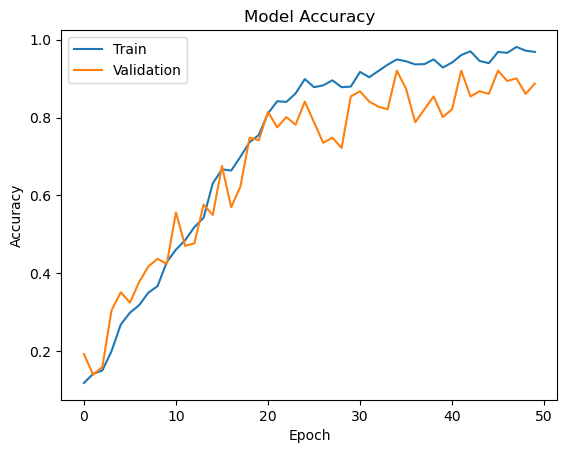

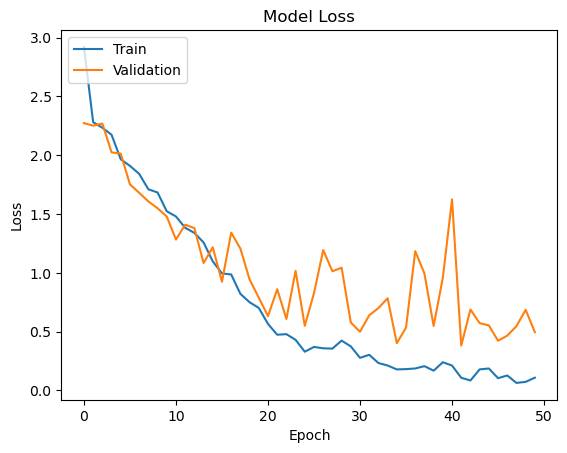

In [22]:
# plot accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [23]:
# Getting the true labels and the predicted labels of your test data
y_true = []
y_pred = []
for images, labels in test_dataset:
  predictions = model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(predictions, axis=1))

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 [==============================] - 2s 2s/step
                    precision    recall  f1-score   support

           Big Ben       0.94      0.94      0.94        16
         Colosseum       0.89      0.89      0.89         9
    Egypt Pyramids       1.00      0.67      0.80         6
      Eiffel Tower       0.95      0.91      0.93        23
     London Bridge       0.95      0.86      0.90        22
             Petra       1.00      0.82      0.90        17
 Statue of Liberty       1.00      1.00      1.00        10
    Sudan Pyramids       0.85      1.00      0.92        23
Sydney Opera House       0.75      1.00      0.86        18
         Taj Mahal       1.00      0.88      0.93        16

          accuracy                           0.91       160
         macro avg       0.93      0.90      0.91       160
      weighted avg       0.92      0.91      0.91       160



<Figure size 2000x1000 with 0 Axes>

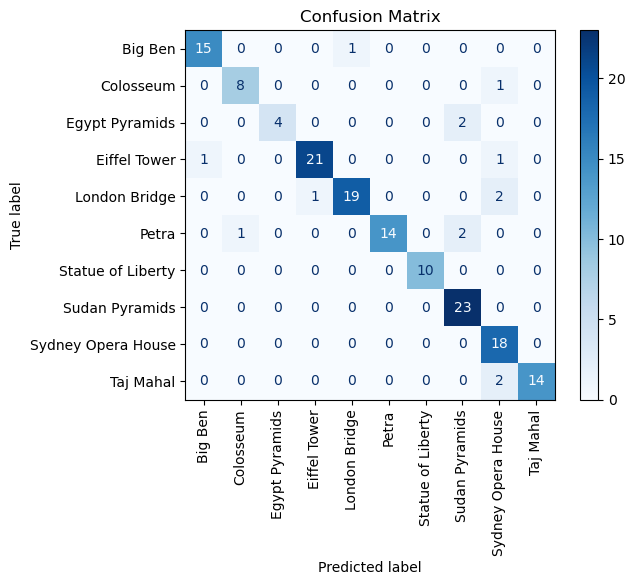

In [24]:
# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Displaying the confusion matrix 
plt.figure(dpi=200, figsize=(10, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')  
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 2s 2s/step


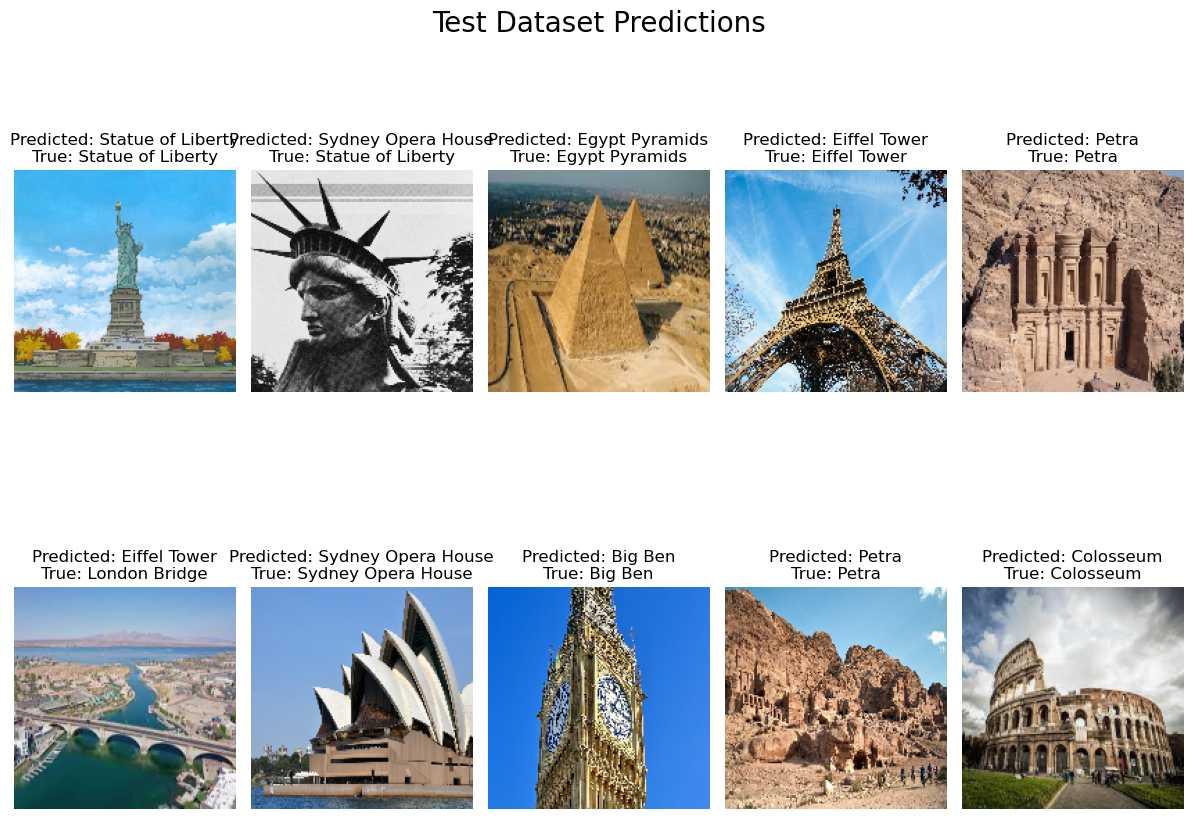

In [25]:
# Getting a batch of images from the test dataset
sample_images, sample_labels = next(iter(test_dataset))
sample_predictions = model.predict(sample_images)

# Mapping the predicted labels to class names
predicted_labels = [class_names[np.argmax(prediction)] for prediction in sample_predictions]

# Creating a figure with a grid of subplots for visualization
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))

# Loop through the subplots
for i in range(2):
    for j in range(5):
        idx = i * 5 + j  
        
        # Preprocess and normalize the image
        image = sample_images[idx] / 255.0
        ax[i, j].set_title(f"Predicted: {predicted_labels[idx]}\nTrue: {class_names[sample_labels[idx]]}")
        ax[i, j].imshow(image)
        ax[i, j].axis("off")

# Increase the resolution of the images
plt.rcParams["figure.dpi"] = 300

# Display the images
plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()
